In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 
from torch.autograd import Variable
# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load and Clean Data

CNNs assume a fixed input size so we need to assume a fixed size and truncate or pad the sentences as needed.

In [2]:
# breath_df = get_breath_df('data_sdx_',full_trace=True)
# breath_df.to_pickle('breath_pickle_full_trace')

In [3]:
breath_df = pd.read_pickle('breath_pickle_full_trace')
breath_df.head(2)

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"
1,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...",30.61,31.40,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386, 2387, 2388, 2389, 2390, 2391, 2392, 239...","(2386, 5525)"


In [4]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [5]:
median_bh = under2['Data_breath_holds'].median()
under2['class'] = np.where(under2['Data_breath_holds'] < median_bh, 0, 1) # create encoded column: short (0), long (1)

In [6]:
q25 = under2['Data_breath_holds'].quantile(.25)
q75 = under2['Data_breath_holds'].quantile(.75)

In [7]:
under2 = under2[(under2['Data_breath_holds'] < q25) | (under2['Data_breath_holds'] > q75)] # only consider breathholds in upper and lower quartiles

In [8]:
under2['class'] = np.where(under2['Data_breath_holds'] < q25, 0, 1) # create encoded column: short (0), long (1)

In [9]:
under2.head()

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end,class
9,"[0.0008, 0.0018, 0.0021, 0.0024, 0.0028, 0.003...",25.44,25.05,"[0.0008, 0.0018, 0.0021, 0.0024, 0.0028, 0.003...","[2205, 2206, 2207, 2208, 2209, 2210, 2211, 221...","(2205, 4709)",0
13,"[0.0004, 0.0011, 0.002, 0.0032, 0.0045, 0.006,...",24.41,24.44,"[0.0004, 0.0011, 0.002, 0.0032, 0.0045, 0.006,...","[2095, 2096, 2097, 2098, 2099, 2100, 2101, 210...","(2095, 4538)",0
14,"[0.0002, 0.0006, 0.001, 0.0015, 0.002, 0.0026,...",26.02,25.66,"[0.0002, 0.0006, 0.001, 0.0015, 0.002, 0.0026,...","[2069, 2070, 2071, 2072, 2073, 2074, 2075, 207...","(2069, 4634)",0
15,"[0.0002, 0.0007, 0.0015, 0.0026, 0.004, 0.0057...",26.43,25.11,"[0.0002, 0.0007, 0.0015, 0.0026, 0.004, 0.0057...","[2070, 2071, 2072, 2073, 2074, 2075, 2076, 207...","(2070, 4580)",0
16,"[0.0016, 0.0021, 0.0028, 0.0037, 0.0047, 0.005...",25.27,25.06,"[0.0016, 0.0021, 0.0028, 0.0037, 0.0047, 0.005...","[2171, 2172, 2173, 2174, 2175, 2176, 2177, 217...","(2171, 4676)",0


# Split and Normalize Data

In [10]:
df = under2

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['Data_breath_holds'], test_size=0.70)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=1)

In [13]:
def normalize(x_train, x_val):
    u = np.mean([item for sublist in x_train for item in sublist])
    std = np.std([item for sublist in x_train for item in sublist])
    
    train = []
    for row in x_train:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        train.append(normalized_row)
    
    val = []
    for row in x_val:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        val.append(normalized_row)
    
    return train, val

In [14]:
x_train2, x_val2 = normalize(x_train, x_val)
x_train2, x_test2 = normalize(x_train, x_test)

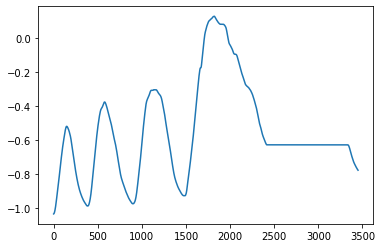

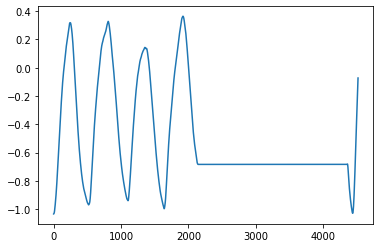

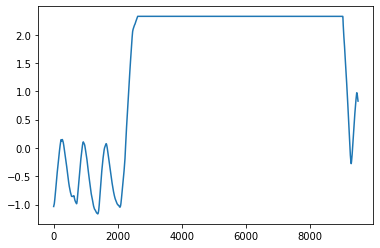

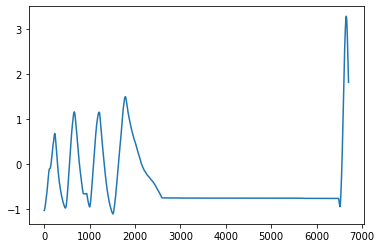

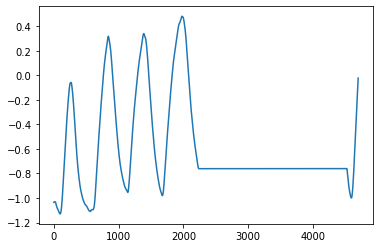

In [15]:
for i in range(5):
    j = np.random.randint(len(x_train2))
    plt.plot(x_train2[j])
    plt.show()

## Equalize Lengths

In [16]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [17]:
def equalize_lengths(df, trim_len):
    equal_traces = []
    for i in range(len(df)):
        curve = df[i]
        if len(curve) > trim_len:
            start_idx = len(curve)-trim_len
            equal_traces.append(curve[start_idx:])
        elif len(curve) < trim_len:
            num_zeros = trim_len - len(curve)
            
            random_nums = (np.random.random_sample(num_zeros)-0.5)
            box_pts = 100
            box = np.ones(box_pts)/box_pts
            random_nums = np.convolve(random_nums, box, mode = 'same')
            random_nums = random_nums[:num_zeros]
            #zeros = np.zeros([1, num_zeros])[0]
            equal_traces.append(np.concatenate((random_nums, curve)))
        else:
            equal_traces.append(curve)
 
    return np.array(equal_traces)

In [18]:
x_train3 = equalize_lengths(x_train2, 10000)
x_val3 = equalize_lengths(x_val2, 10000)
x_test3 = equalize_lengths(x_test2, 10000)

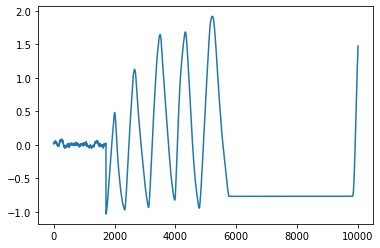

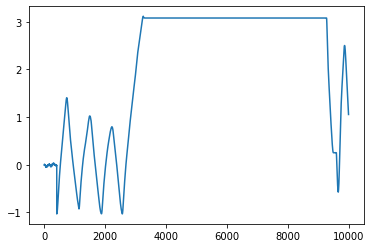

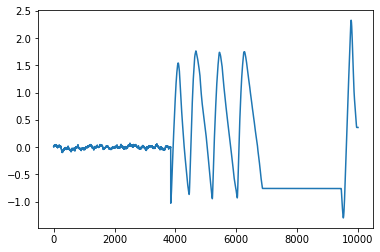

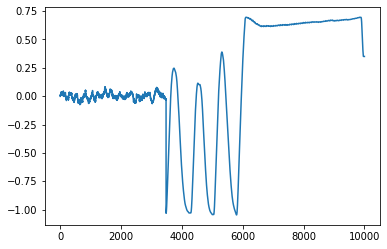

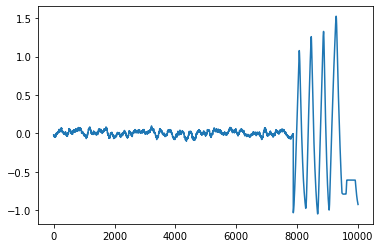

In [19]:
for i in range(5):
    j = np.random.randint(len(x_train3))
    plt.plot(x_train3[j])
    plt.show()

## Playing and debugging CNN layers

In [20]:
D = 300
N = 40

In [21]:
x = x_train3[:2]
x.shape

(2, 10000)

In [22]:
x = torch.tensor(x,dtype=torch.float32)
x.shape

torch.Size([2, 10000])

In [23]:
x1 = torch.unsqueeze(x, dim=1)  # needs to convert x to (batch, embedding_dim, sentence_len)
x1.shape


torch.Size([2, 1, 10000])

In [24]:
conv_3=nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3)

In [25]:
x3 = conv_3(x1)
x3.size()

torch.Size([2, 100, 9998])

In [26]:
conv_4 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=4)
conv_5 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=5)

In [27]:
x4 = conv_4(x1)
x5 = conv_5(x1)
print(x4.size(), x5.size())

torch.Size([2, 100, 9997]) torch.Size([2, 100, 9996])


In [28]:
# 100 3-gram detectors
x3 = nn.ReLU()(x3)
x3 = nn.MaxPool1d(kernel_size = 9998)(x3)
x3.size()

torch.Size([2, 100, 1])

In [29]:
# 100 4-gram detectors
x4 = nn.ReLU()(x4)
x4 = nn.MaxPool1d(kernel_size = 9997)(x4)
x4.size()

torch.Size([2, 100, 1])

In [30]:
# 100 5-gram detectors
x5 = nn.ReLU()(x5)
x5 = nn.MaxPool1d(kernel_size = 9996)(x5)
x5.size()

torch.Size([2, 100, 1])

In [31]:
# concatenate x3, x4, x5
out = torch.cat([x3, x4, x5], 2)
out.size()

torch.Size([2, 100, 3])

In [32]:
out = out.view(out.size(0), -1)
out.size()

torch.Size([2, 300])

## CNN Model

In [33]:
class myCNN(nn.Module):
    
    def __init__(self, D):
        super(myCNN, self).__init__()
        self.conv_3 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=5)
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(300, 1)
        
    def forward(self, x):
        x = torch.unsqueeze(x, dim=1)
        x3 = F.relu(self.conv_3(x))
        x4 = F.relu(self.conv_4(x))
        x5 = F.relu(self.conv_5(x))
        
        x3 = nn.MaxPool1d(kernel_size = 9998)(x3)
        x4 = nn.MaxPool1d(kernel_size = 9997)(x4)
        x5 = nn.MaxPool1d(kernel_size = 9996)(x5)
        
        out = torch.cat([x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        
        return self.fc(out) 

In [34]:
# Testing the model
model = myCNN(1)

In [35]:
x = x_train3[:10]
x = torch.tensor(x,dtype=torch.float32)
model(x)

tensor([[ 0.0605],
        [-0.1634],
        [ 0.1358],
        [-0.3524],
        [-0.8888],
        [ 0.2475],
        [-0.8715],
        [-0.1162],
        [ 0.7575],
        [ 0.4429]], grad_fn=<AddmmBackward0>)

# Dataset and Dataloader

In [36]:
from torch.utils.data import Dataset

class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [37]:
dataset = timeseries(x_train3,y_train)
valid_dataset = timeseries(x_val3,y_val)
test_dataset = timeseries(x_test3,y_test)

In [38]:
train_loader = DataLoader(dataset,shuffle=True,batch_size=50)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=50)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=50)

## Training

In [39]:
x_train4 = x_train3

In [40]:
#def train(model, x_train, y_train):
model = myCNN(1).cuda()

In [47]:
# this filters parameters with p.requires_grad=True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.01)
criterion = torch.nn.MSELoss()

In [48]:
def train_epocs(model, epochs=10, lr=0.01, fname='1'):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    
    losses = []
    for i in range(epochs):
        model.train()
        #losses = []
        for x, y in train_loader:
            x = x.cuda()
            y = y.unsqueeze(1).cuda()
            y_hat = model(x).unsqueeze(1).cuda()
            #loss = F.binary_cross_entropy_with_logits(y_hat, y)
            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(loss.item())
        losses.append(loss.item()/len(train_loader))
        test_metrics(model)
    filename = 'losses_' + fname + '.csv'
    np.savetxt(filename, losses, delimiter=",")
    return losses

In [49]:
def test_metrics(m):
    m.eval()
    losses = []
    for x, y in val_loader:
        x = x.cuda()
        y = y.unsqueeze(1).cuda()
        y_hat = m(x).unsqueeze(1).cuda()
        loss = torch.nn.MSELoss(y_hat, y)
        losses.append(loss.item())
        y_pred = y_hat > 0
        correct = (y_pred.float() == y).float().sum()
        accuracy = correct/y_pred.shape[0]
    print("test loss %.3f and accuracy %.3f" % (np.mean(losses), accuracy))

In [50]:
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1]

In [51]:
losses = []
for lr in learning_rates:
    loss = train_epocs(model, epochs=30, lr=lr, fname=str(lr))
    losses.append(loss)

RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 7.80 GiB total capacity; 766.74 MiB already allocated; 155.06 MiB free; 790.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [55]:
losses

[0.14556742906570436,
 [0.12657766342163085],
 [0.1470730185508728],
 [0.1292658567428589],
 [0.1273938775062561],
 [0.12751874923706055],
 [0.13949084281921387],
 [0.1294490098953247]]

In [ ]:
plt.plot(losses)
plt.ylim(0,1)
plt.title('Loss')
plt.show()

In [ ]:
# data loader

In [74]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 5            |        cudaMalloc retries: 5         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |     771 MB |     784 MB |    2560 MB |    1788 MB |\n|       from large pool |     771 MB |     784 MB |    2560 MB |    1788 MB |\n|       from small pool |       0 MB |       0 MB |       0 MB |       0 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |     771 MB |     784 MB |    2560 MB |    1788 MB |\n|       from large pool |     771 MB |     784 MB |